In [4]:
! pip install nltk

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
pip install textstat

     |████████████████████████████████| 102kB 3.9MB/s 
     |████████████████████████████████| 1.9MB 12.7MB/s 


In [10]:
pip install lexicalrichness

  Created wheel for lexicalrichness: filename=lexicalrichness-0.1.3-py2.py3-none-any.whl size=8742 sha256=e41abdec93ca130cbc5b945006b46e38a0ec17f53c85b948cd7acb1da67d70a9
  Stored in directory: /root/.cache/pip/wheels/ac/04/68/c48c4001edf1647b80b549897fd80082286ec253e343c73116
Successfully built lexicalrichness


In [14]:
from nltk.corpus import stopwords    
stop_words = set(stopwords.words('english'))

from nltk.tag import pos_tag
from nltk import word_tokenize
from collections import Counter

import textstat
from lexicalrichness import LexicalRichness

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

In [76]:
pd.set_option('display.max_columns', 500)

df = pd.read_csv('https://raw.githubusercontent.com/priyanshi9692/CMPE257-Detect-Covid19-Misinformation/main/corona_fake.csv')
df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)

df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

In [77]:
df.isnull().sum()

title     0
text      0
source    0
label     0
dtype: int64

In [18]:
df['title_num_uppercase'] = df['title'].str.count(r'[A-Z]')
# df['title_len'] = df['title'].str.len()

df['text_num_uppercase'] = df['text'].str.count(r'[A-Z]')
df['text_len'] = df['text'].str.len()

# df['title_pct_uppercase'] = df.title_num_uppercase.div(df.title_len)
df['text_pct_uppercase'] = df.text_num_uppercase.div(df.text_len)

In [19]:
df['title_num_stop_words'] = df['title'].str.split().apply(lambda x: len(set(x) & stop_words))
df['text_num_stop_words'] = df['text'].str.split().apply(lambda x: len(set(x) & stop_words))

# df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# df['title_pct_stop_words'] = df['title_num_stop_words'] / df['title_word_count']
df['text_pct_stop_words'] = df['text_num_stop_words'] / df['text_word_count']

# df.drop(['title_num_uppercase', 'title_len', 'text_num_uppercase', 'text_len', 'title_num_stop_words', 'text_num_stop_words', 'title_word_count', 'text_word_count'], axis=1, inplace=True)

### Stop Words in Title

In [20]:
x1 = df.loc[df['label']=='TRUE']['title_num_stop_words']
x2 = df.loc[df['label'] == 'FAKE']['title_num_stop_words']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Stop Words in title', template="plotly_white")
fig.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Stop Words in title', template="plotly_white")
fig.show()

Fake news titles have fewer stop-words than those of real news.

### Capital Letter in Title

In [23]:
x1 = df.loc[df['label']=='TRUE']['title_num_uppercase']
x2 = df.loc[df['label'] == 'FAKE']['title_num_uppercase']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Capital letter in title', template="plotly_white")
fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Capital Letter in title', template="plotly_white")
fig.show()

On average, fake news have way more words that appear in capital letters in the title.This makes us to think that fake news is targeted for audiences who are likely to be influenced by titles.

In [25]:
df.loc[df['label']=='TRUE']['title_num_uppercase'].describe()

count    586.000000
mean       4.583618
std        5.223288
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       60.000000
Name: title_num_uppercase, dtype: float64

In [26]:
df.loc[df['label']=='FAKE']['title_num_uppercase'].describe()

count    578.000000
mean      15.515571
std       22.839139
min        0.000000
25%        3.000000
50%        7.000000
75%       14.000000
max      114.000000
Name: title_num_uppercase, dtype: float64

In [27]:
df.drop(['text_num_uppercase', 'text_len', 'text_num_stop_words', 'text_word_count'], axis=1, inplace=True)

In [30]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

df['token'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [31]:
df = df[['title', 'text', 'source', 'label', 'title_num_uppercase', 'text_pct_uppercase', 'title_num_stop_words', 'text_pct_stop_words', 'NNP']].rename(columns={'NNP': 'NNP_title'})

In [32]:
x1 = df.loc[df['label']=='TRUE']['NNP_title']
x2 = df.loc[df['label'] == 'FAKE']['NNP_title']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Proper nouns in title', template="plotly_white")
fig.show()

In [33]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Proper nouns in title', template="plotly_white")
fig.show()

Fake news titles have more proper nouns. Apparently the use of proper nouns in titles are very significant in differentiating fake from real.

Overall, these results suggest that the writers of fake news are attempting to attracting attention by using all capitalized words, and squeeze as much substance into the titles as possible by skipping stop-words and increase proper nouns. 

Here is an example: 

Fake news title: "FULL TRANSCRIPT OF “SMOKING GUN” BOMBSHELL INTERVIEW: PROF. FRANCES BOYLE EXPOSES THE BIOWEAPONS ORIGINS OF THE COVID-19 CORONAVIRUS"

Real news title: "Why outbreaks like coronavirus spread exponentially, and how to 'flatten the curve'"

We will find out whether these apply to article bodies shortly.

In [34]:
df.loc[df['label']=='TRUE']['NNP_title'].describe()

count    586.000000
mean       1.218430
std        1.811663
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max       12.000000
Name: NNP_title, dtype: float64

In [35]:
df.loc[df['label']=='FAKE']['NNP_title'].describe()

count    578.000000
mean       4.759516
std        4.453412
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max       24.000000
Name: NNP_title, dtype: float64

In [36]:
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)

In [37]:
df['num_negation'] = df['text'].str.lower().str.count("no|not|never|none|nothing|nobody|neither|nowhere|hardly|scarcely|barely|doesn’t|isn’t|wasn’t|shouldn’t|wouldn’t|couldn’t|won’t|can't|don't")

df['num_interrogatives_title'] = df['title'].str.lower().str.count("what|who|when|where|which|why|how")
df['num_interrogatives_text'] = df['text'].str.lower().str.count("what|who|when|where|which|why|how")

Python library - textstat to calculate statistics from text to determine readability, complexity and grade level of any article. The meaning of each statistical feature value can be found [here](https://pypi.org/project/textstat/).

In [38]:
reading_ease = []
for doc in df['text']:
    reading_ease.append(textstat.flesch_reading_ease(doc))
    
smog = []
for doc in df['text']:
    smog.append(textstat.smog_index(doc))
    
kincaid_grade = []
for doc in df['text']:
    kincaid_grade.append(textstat.flesch_kincaid_grade(doc))
    
liau_index = []
for doc in df['text']:
    liau_index.append(textstat.coleman_liau_index(doc))
    
readability_index = []
for doc in df['text']:
    readability_index.append(textstat.automated_readability_index(doc))

readability_score = []
for doc in df['text']:
    readability_score.append(textstat.dale_chall_readability_score(doc))
    
difficult_words = []
for doc in df['text']:
    difficult_words.append(textstat.difficult_words(doc))

write_formula = []
for doc in df['text']:
    write_formula.append(textstat.linsear_write_formula(doc))

gunning_fog = []
for doc in df['text']:
    gunning_fog.append(textstat.gunning_fog(doc))

text_standard = []
for doc in df['text']:
    text_standard.append(textstat.text_standard(doc))
    
df['flesch_reading_ease'] = reading_ease
df['smog_index'] = smog
df['flesch_kincaid_grade'] = kincaid_grade
df['automated_readability_index'] = readability_index
df['dale_chall_readability_score'] = readability_score
df['difficult_words'] = difficult_words
df['linsear_write_formula'] = write_formula
df['gunning_fog'] = gunning_fog
df['text_standard'] = text_standard

Type-Token Ratio (TTR), reference: https://pypi.org/project/lexicalrichness/

In [39]:
ttr = []
for doc in df['text']:
    lex = LexicalRichness(doc)
    ttr.append(lex.ttr)

df['ttr'] = ttr

* Number of power words in the text (https://buffer.com/library/words-and-phrases-that-convert-ultimate-list/).

* Number of casual words in the text (https://www.researchgate.net/figure/Ten-Most-Frequent-Causal-Words_fig8_309156646).

* Number of tentative words in the text (https://lo.unisa.edu.au/pluginfile.php/1687800/mod_resource/content/0/Tentative%20language_Sept%202017.pdf#:~:text=Examples%20of%20tentative%20phrases%2Fvocabulary%20include%3A&text=may%2Fmight%2Fcan%2Fcould,each%20sentence%20becomes%20more%20tentative)

* Number of emotion words in the text (https://www.thepersuasionrevolution.com/380-high-emotion-persuasive-words/)

In [40]:
df['num_powerWords_text'] = df['text'].str.lower().str.count('improve|trust|immediately|discover|profit|learn|know|understand|powerful|best|win|more|bonus|exclusive|extra|you|free|health|guarantee|new|proven|safety|money|now|today|results|protect|help|easy|amazing|latest|extraordinary|how to|worst|ultimate|hot|first|big|anniversary|premiere|basic|complete|save|plus|create')
df['num_casualWords_text'] = df['text'].str.lower().str.count('make|because|how|why|change|use|since|reason|therefore|result')
df['num_tentativeWords_text'] = df['text'].str.lower().str.count('may|might|can|could|possibly|probably|it is likely|it is unlikely|it is possible|it is probable|tends to|appears to|suggests that|seems to')
df['num_emotionWords_text'] = df['text'].str.lower().str.count('ordeal|outrageous|provoke|repulsive|scandal|severe|shameful|shocking|terrible|tragic|unreliable|unstable|wicked|aggravate|agony|appalled|atrocious|corruption|damage|disastrous|disgusted|dreadful|eliminate|harmful|harsh|inconsiderate|enraged|offensive|aggressive|frustrated|controlling|resentful|anger|sad|fear|malicious|infuriated|critical|violent|vindictive|furious|contrary|condemning|sarcastic|poisonous|jealous|retaliating|desperate|alienated|unjustified|violated')

### Capital Letter in Article Body

In [41]:
x1 = df.loc[df['label']=='TRUE']['text_pct_uppercase']
x2 = df.loc[df['label'] == 'FAKE']['text_pct_uppercase']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Capital Letter in Article body', template="plotly_white")
fig.show()

In [42]:
df.loc[df['label']=='TRUE']['text_pct_uppercase'].describe()

count    586.000000
mean       0.026935
std        0.014309
min        0.000000
25%        0.018105
50%        0.024336
75%        0.033340
max        0.142857
Name: text_pct_uppercase, dtype: float64

In [43]:
df.loc[df['label']=='FAKE']['text_pct_uppercase'].describe()

count    578.000000
mean       0.041440
std        0.068751
min        0.000000
25%        0.023955
50%        0.031248
75%        0.040978
max        0.819048
Name: text_pct_uppercase, dtype: float64

On average, fake news have way more words that appear in capital letters in the article text.

### Stop Words in Article body

In [44]:
x1 = df.loc[df['label']=='TRUE']['text_pct_stop_words']
x2 = df.loc[df['label'] == 'FAKE']['text_pct_stop_words']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Stop Words in Article Body', template="plotly_white")
fig.show()

In [45]:
df.loc[df['label']=='TRUE']['text_pct_stop_words'].describe()

count    586.000000
mean       0.159447
std        0.087451
min        0.000000
25%        0.080391
50%        0.156158
75%        0.220039
max        0.560000
Name: text_pct_stop_words, dtype: float64

In [46]:
df.loc[df['label']=='FAKE']['text_pct_stop_words'].describe()

count    578.000000
mean       0.144173
std        0.101957
min        0.000000
25%        0.065178
50%        0.105671
75%        0.209584
max        0.500000
Name: text_pct_stop_words, dtype: float64

It seems there isn't a significant difference on stop words in article text between fake news and real news.

### VBG	(Verb, gerund or present participle)

In [47]:
x1 = df.loc[df['label']=='TRUE']['VBG']
x2 = df.loc[df['label'] == 'FAKE']['VBG']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of verbs in Text', template="plotly_white")
fig.show()

There is no significant difference on the number of verbs in real news or fake news.

### NNP	(Proper noun, singular)

In [48]:
x1 = df.loc[df['label']=='TRUE']['NNP']
x2 = df.loc[df['label'] == 'FAKE']['NNP']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Proper noun in Article Body', template="plotly_white")
fig.show()

In [49]:
df.loc[df['label']=='TRUE']['NNP'].describe()

count    586.000000
mean      35.981229
std       55.619845
min        0.000000
25%        3.000000
50%       12.000000
75%       47.750000
max      450.000000
Name: NNP, dtype: float64

In [50]:
df.loc[df['label']=='FAKE']['NNP'].describe()

count    578.000000
mean      72.198962
std       96.609921
min        0.000000
25%        7.000000
50%       40.000000
75%       95.750000
max      747.000000
Name: NNP, dtype: float64

It seems fake news have a little bit more Proper noun than the real ones.

### Negation words

In [51]:
x1 = df.loc[df['label']=='TRUE']['num_negation']
x2 = df.loc[df['label'] == 'FAKE']['num_negation']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Negations in Article Bodies', template="plotly_white")
fig.show()

In [52]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Negations in Article Bodies', template="plotly_white")
fig.show()

In [53]:
df.loc[df['label']=='TRUE']['num_negation'].describe()

count    586.000000
mean      10.044369
std       13.854115
min        0.000000
25%        2.000000
50%        4.000000
75%       13.000000
max       88.000000
Name: num_negation, dtype: float64

In [54]:
df.loc[df['label']=='FAKE']['num_negation'].describe()

count    578.000000
mean      14.368512
std       19.645582
min        0.000000
25%        1.000000
50%        6.000000
75%       19.000000
max      144.000000
Name: num_negation, dtype: float64

On average, fake news have a little more negation words than the real ones.

### Bracket

In [55]:
x1 = df.loc[df['label']=='TRUE']['(']
x2 = df.loc[df['label'] == 'FAKE']['(']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Brackets in Article Bodies', template="plotly_white")
fig.show()

In [56]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Brackets in Article Bodies', template="plotly_white")
fig.show()

In [57]:
x1 = df.loc[df['label']=='TRUE'][')']
x2 = df.loc[df['label'] == 'FAKE'][')']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Brackets in Text', template="plotly_white")
fig.show()

In [58]:
df.loc[df['label']=='FAKE']['('].describe()

count    578.000000
mean       3.828720
std        7.080381
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       44.000000
Name: (, dtype: float64

In [59]:
df.loc[df['label']=='TRUE']['('].describe()

count    586.000000
mean       1.713311
std        3.245467
min        0.000000
25%        0.000000
50%        0.500000
75%        2.000000
max       26.000000
Name: (, dtype: float64

### Type-token ratio

In [60]:
x1 = df.loc[df['label']=='TRUE']['ttr']
x2 = df.loc[df['label'] == 'FAKE']['ttr']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show()

In [61]:
df.loc[df['label']=='TRUE']['ttr'].describe()

count    586.000000
mean       0.596363
std        0.159964
min        0.149926
25%        0.461591
50%        0.599435
75%        0.718308
max        1.000000
Name: ttr, dtype: float64

In [62]:
df.loc[df['label']=='FAKE']['ttr'].describe()

count    578.000000
mean       0.602498
std        0.192414
min        0.204246
25%        0.445201
50%        0.555322
75%        0.759474
max        1.000000
Name: ttr, dtype: float64

In [63]:
x1 = df.loc[df['source']=='https://www.health.harvard.edu/']['text_pct_stop_words']
x2 = df.loc[df['source']=='https://www.naturalnews.com/']['text_pct_stop_words']

group_labels = ['Health Harvard', 'Natural News']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Stop Words in Article Bodies', template="plotly_white")
fig.show()

In [64]:
x1 = df.loc[df['source']=='https://www.health.harvard.edu/']['ttr']
x2 = df.loc[df['source'] == 'https://www.naturalnews.com/']['ttr']

group_labels = ['Harvard', 'Natural News']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show()

A low TTR means a document has more word redundancy and a high TTR means a document has more word diversity.

Fake news appear to have more proper nouns in both titles and article bodies.

In [65]:
X, y = df.drop(['title', 'text', 'source', 'label', 'text_standard'], axis = 1), df['label']
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [66]:
# Set dual = false if number of features > number of examples and vice versa. 
# This solves the SVM optimization problem using the dual formulation.

svc=LinearSVC(dual=False)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)

[0.84615385 0.82051282 0.79487179 0.82051282 0.87068966 0.8362069
 0.81034483 0.87931034 0.8362069  0.8362069 ]


In [67]:
print(scores.mean())

0.8351016799292662


In [68]:
C_range=list(range(1,26))
acc_score=[]
for c in C_range:
    svc = LinearSVC(dual=False, C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
    
C_values=list(range(1,26))
fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
fig.update_layout(xaxis_title='Value of C for SVC',
                   yaxis_title='Cross Validated Accuracy', template='plotly_white',xaxis = dict(dtick = 1))
fig.show()

From the above plot we can see that accuracy is close to 84.2% for C=1 and then it drops around 83.8% and remains constant.

In [70]:
C_range=list(np.arange(0.1,6,0.1))
acc_score=[]
for c in C_range:
    svc = LinearSVC(dual=False, C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

In [71]:
C_values=list(np.arange(0.1,6,0.1))
fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
fig.update_layout(xaxis_title='Value of C for SVC',
                   yaxis_title='Cross Validated Accuracy', template='plotly_white',xaxis = dict(dtick = 1))
fig.show()

Accuracy score is the highest for C=0.7.

In [72]:
X, y = df.drop(['title', 'text', 'source', 'label', 'text_standard'], axis = 1), df['label']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf = LinearSVC(dual=False, C=0.7)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

print('Training accuracy', accuracy_score(y_train, clf.predict(X_train)))
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy 0.8678839957035446
[[ 88  23]
 [ 15 107]]
Accuracy 0.8369098712446352
              precision    recall  f1-score   support

        FAKE       0.85      0.79      0.82       111
        TRUE       0.82      0.88      0.85       122

    accuracy                           0.84       233
   macro avg       0.84      0.83      0.84       233
weighted avg       0.84      0.84      0.84       233



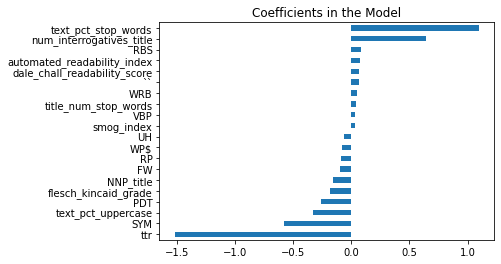

In [75]:
import matplotlib.pyplot as plt

coef = pd.Series([item for sublist in clf.coef_ for item in sublist], index = X_train.columns)

imp_coef = pd.concat([coef.sort_values().head(10),
                    coef.sort_values().tail(10)])

imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model");